In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from helper_fuctions import *

In [2]:
content_path = "images/Content_images/content1.jpg"
style_path = "images/Style_images/style1.jpg"

#loading images into tensor and resizing style and content images
content_img = load_img(content_path,img_rows=400)
style_img = load_img(style_path,img_rows=400)
combination_img = load_img(content_path,img_rows=400)

#preprocessing images for vgg
content_img = preprocess_img(content_img)
style_img = preprocess_img(style_img)
combination_img = tf.Variable(preprocess_img(combination_img))

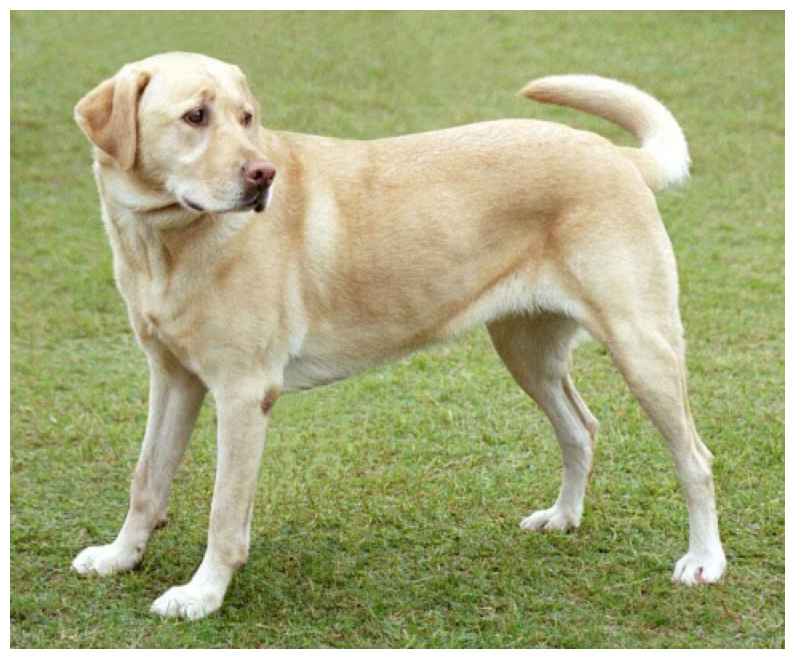

In [3]:
show(combination_img)

In [4]:
vgg = tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False)
vgg.trainable = False
class modVGG(tf.keras.Model):
    def __init__(self):
        super(modVGG,self).__init__()
        self.choose = "style"
        self.chosen_style = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
        self.chosen_content = 'block5_conv2'
        self.model = vgg
    def call(self,x):
        features = []
        if self.choose=='style':
            for l in self.model.layers:
                x = l(x)
                if l.name in self.chosen_style:
                    features.append(x)
        elif self.choose=='content':
            for l in self.model.layers:
                x = l(x)
                if l.name is self.chosen_content:
                    features = x
        return features
trainer = modVGG()

In [5]:
optim = tf.keras.optimizers.Adam(learning_rate=10)
style_weight = 2e-7
content_weight = 2.5e-8
epochs = 500
for epoch in range(1,epochs+1):
    with tf.GradientTape() as tape:
        tape.watch(combination_img)
        trainer.choose = 'style'
        style_features = trainer(style_img)
        combination_features_wrt_style = trainer(combination_img)
        trainer.choose = 'content'
        content_features = trainer(content_img)
        combination_features_wrt_content = trainer(combination_img)
        # Content loss...
        content_loss = content_weight*content_fn(content_features,combination_features_wrt_content)
        # Style loss...
        style_loss = 0
        for style_feat, combination_feat in zip(style_features,combination_features_wrt_style):
            style_feat = tf.squeeze(style_feat)
            combination_feat = tf.squeeze(combination_feat)
            style_loss+=style_weight*style_fn(style_feat,combination_feat)
        total_loss = style_loss + content_loss
    if epoch%100==0:
        print(f"Iteration: {epoch} | content loss: {content_loss} | style loss: {style_loss} | total loss: {total_loss}")
    grads = tape.gradient(total_loss,[combination_img])
    optim.apply_gradients(zip(grads,[combination_img]))

Iteration: 100 | content loss: 48.44810485839844 | style loss: 953.338623046875 | total loss: 1001.7867431640625
Iteration: 200 | content loss: 45.71621322631836 | style loss: 671.5740966796875 | total loss: 717.290283203125
Iteration: 300 | content loss: 42.57547378540039 | style loss: 408.927978515625 | total loss: 451.5034484863281
Iteration: 400 | content loss: 46.49650573730469 | style loss: 572.2061767578125 | total loss: 618.7026977539062
Iteration: 500 | content loss: 41.924991607666016 | style loss: 440.0496520996094 | total loss: 481.9746398925781


(-0.5, 484.5, 399.5, -0.5)

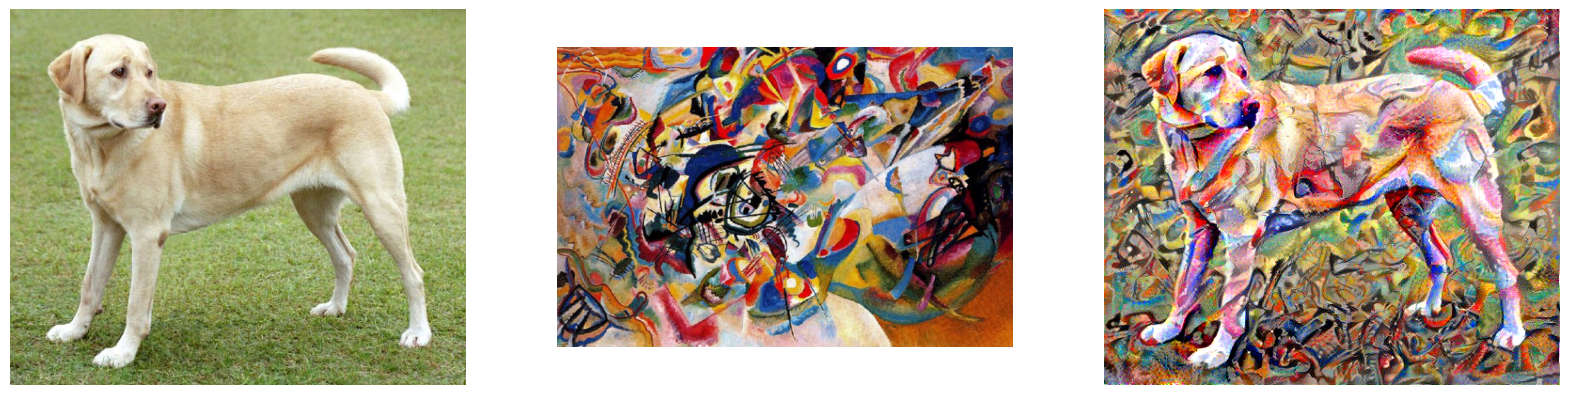

In [7]:
plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(deprocess_image(content_img.numpy()))
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(deprocess_image(style_img.numpy()))
plt.axis(False)
plt.subplot(1,3,3)
plt.imshow(deprocess_image(combination_img.numpy()))
plt.axis(False)